In [1]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

c:\Users\Hampus\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


##N-BEATS


In [2]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4
num_stacks = 4

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
    
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        
        forecasts = torch.tensor([0 for _ in range(self.forecast_length)])
        for block in self.blocks:
            backcast, forecast = block(x)    
            x = x - backcast.squeeze()
            forecasts =  forecasts + forecast.squeeze()
        fc = forecasts
        return x, fc
        
class Nbeat(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 num_stacks: int
                 ):
        super(Nbeat, self).__init__()
        self.forecast_length = forecast_length    

        self.stacks = nn.ModuleList([NbeatsStack(input_size, backcast_length, forecast_length, hidden_units, hidden_layers, num_blocks) for _ in range(num_stacks)])

    def forward(self, x):
        backcasts = []
        fcs = torch.tensor([0 for _ in range(self.forecast_length)])
        for stack in self.stacks:
            backcast, forecast = stack(x)
            fcs = fcs + forecast
            x = backcast.squeeze()

       
        return backcast, fcs


##Get Data

In [44]:
GetFacebookInformation = yf.Ticker("META")
facebook_history = GetFacebookInformation.history(period="max")
print(facebook_history)


                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.049999   45.000000   38.000000   38.230000   
2012-05-21 00:00:00-04:00   36.529999   36.660000   33.000000   34.029999   
2012-05-22 00:00:00-04:00   32.610001   33.590000   30.940001   31.000000   
2012-05-23 00:00:00-04:00   31.370001   32.500000   31.360001   32.000000   
2012-05-24 00:00:00-04:00   32.950001   33.209999   31.770000   33.029999   
...                               ...         ...         ...         ...   
2024-02-14 00:00:00-05:00  467.929993  474.109985  466.089996  473.279999   
2024-02-15 00:00:00-05:00  475.279999  488.619995  472.220001  484.029999   
2024-02-16 00:00:00-05:00  478.109985  478.959991  469.209991  473.320007   
2024-02-20 00:00:00-05:00  469.720001  476.179993  466.559998  471.750000   
2024-02-21 00:00:00-05:00  469.714996  469.000000  461.790009  464.555389   

In [5]:
train_data_set = facebook_history[:2800]
test_data_set = facebook_history[2800:]

In [6]:
#x_train = []
#y_train = []
#for i in range(backcast_length, len(train_data_set) - forecast_length):
#    x_res = []
#    for b in range(backcast_length):
#        x_res.append(train_data_set.iloc[i - backcast_length + b, 1].tolist())
#    x_train.append(x_res)
#
#    y_res = []
#    for f in range(forecast_length):
#        y_res.append(train_data_set.iloc[i + f, 1].tolist())
#    y_train.append(y_res)

In [124]:
#Pre-process data
def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):
        x = []
        for b in range(backcast):
            x.append(dataset.iloc[i - backcast + b, 1].tolist())
        
        #Normalize
        mx = max(x) 
        #x = [elem/ mx for elem in x]
        x_l.append(x)


        y = []
        for f in range(forecast_length):
            y.append(dataset.iloc[i + f, 1].tolist())

        #Normalize
        
        #y = [elem/mx for elem in y] 
        y_l.append(y)

    return x_l,y_l

x_train, y_train = pre_process(train_data_set, backcast_length, forecast_length)
x_test, y_test = pre_process(test_data_set, backcast_length, forecast_length)


In [125]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[45.0, 36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273], [36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273], [33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836], [32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945], [33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727], [32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000

##Define model


In [141]:
model = Nbeat(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks,
                    num_stacks)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Nbeat(
  (stacks): ModuleList(
    (0-3): 4 x NbeatsStack(
      (blocks): ModuleList(
        (0-3): 4 x Block(
          (model): Sequential(
            (0): Linear(in_features=10, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=128, bias=True)
            (5): ReLU()
            (6): Linear(in_features=128, out_features=128, bias=True)
            (7): ReLU()
            (8): Linear(in_features=128, out_features=15, bias=True)
          )
        )
      )
    )
  )
)


In [142]:
##Train
num_epochs = 1
train_loss = []
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    
    for i in range(len(x_train)):
        x = torch.Tensor(x_train[i])
        y = torch.Tensor(y_train[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
       
        train_outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        #print(forecasts)
        #print("y  ",y)
        #print(loss.item())

        
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(epoch)
    

        

tensor([-0.6486,  0.6527,  0.7195, -0.3388, -2.2186], grad_fn=<AddBackward0>)
y   tensor([27.6500, 27.7600, 27.1700, 27.3500, 27.7600])
780.1270141601562
tensor([2.0888e+14, 2.7806e+14, 2.6759e+14, 2.8223e+14, 3.0539e+14],
       grad_fn=<AddBackward0>)
y   tensor([27.7600, 27.1700, 27.3500, 27.7600, 28.0700])
7.309355816759308e+28
tensor([2.1552e+14, 2.8691e+14, 2.7610e+14, 2.9120e+14, 3.1510e+14],
       grad_fn=<AddBackward0>)
y   tensor([27.1700, 27.3500, 27.7600, 28.0700, 27.7700])
7.781563186374078e+28
tensor([2.1639e+14, 2.8807e+14, 2.7722e+14, 2.9238e+14, 3.1638e+14],
       grad_fn=<AddBackward0>)
y   tensor([27.3500, 27.7600, 28.0700, 27.7700, 28.1000])
7.844824480015248e+28
tensor([2.1749e+14, 2.8953e+14, 2.7862e+14, 2.9386e+14, 3.1798e+14],
       grad_fn=<AddBackward0>)
y   tensor([27.7600, 28.0700, 27.7700, 28.1000, 28.3200])
7.92445774601588e+28
tensor([2.1784e+14, 2.9000e+14, 2.7907e+14, 2.9434e+14, 3.1849e+14],
       grad_fn=<AddBackward0>)
y   tensor([28.0700, 27.770

In [143]:
print(train_outputs)




[-0.6486424207687378, 208878805450752.0, 215519344984064.0, 216393807036416.0, 217489342464000.0, 217840573480960.0, 218706311380992.0, 219933128523776.0, 220108802752512.0, 219036168224768.0, 221581037010944.0, 224948710801408.0, 230259018432512.0, 234719140642816.0, 239489406468096.0, 244130336735232.0, 248885335293952.0, 252952098897920.0, 257350061522944.0, 260703390793728.0, 262181916508160.0, 261850415497216.0, 261402614824960.0, 261162616750080.0, 260617424338944.0, 260096391118848.0, 260094394630144.0, 258743929405440.0, 257297649500160.0, 256499221790720.0, 255357800677376.0, 253039038431232.0, 250667763499008.0, 249076109017088.0, 247500610994176.0, 244272053878784.0, 241621085978624.0, 240088235638784.0, 238110453530624.0, 233166660960256.0, 227201421148160.0, 222996698497024.0, 217456106799104.0, 210071766171648.0, 203553381548032.0, 198671647899648.0, 193447222837248.0, 186457348112384.0, 180444880437248.0, 178187925454848.0, 176932503158784.0, 175430741000192.0, 175194618

[27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727, 27.760000228881836, 28.06999969482422, 27.770000457763672, 28.100000381469727, 28.31999969482422, 30.100000381469727, 32.08000183105469, 32.18000030517578, 31.93000030517578, 32.5, 33.45000076293945, 33.02000045776367, 33.439998626708984, 32.900001525878906, 32.189998626708984, 31.989999771118164, 31.729999542236328, 31.440000534057617, 31.6299991607666, 31.899999618530273, 32.880001068115234, 32.47999954223633, 31.559999465942383, 31.399999618530273, 31.06999969482422, 30.5, 28.59000015258789, 29.290000915527344, 29.5, 29.469999313354492, 29.0, 29.450000762939453, 29.489999771118164, 28.229999542236328, 24.540000915527344, 24.040000915527344, 23.3700008392334, 21.579999923706055, 20.84000015258789, 22.15999984741211, 22.149999618530273, 22.450000762939453, 21.149999618530273, 21.170000076293945, 21.81999969482422, 22.450000762939453, 21.600000381469727, 21.40999984741211, 20.479999542236328, 20.0799999237

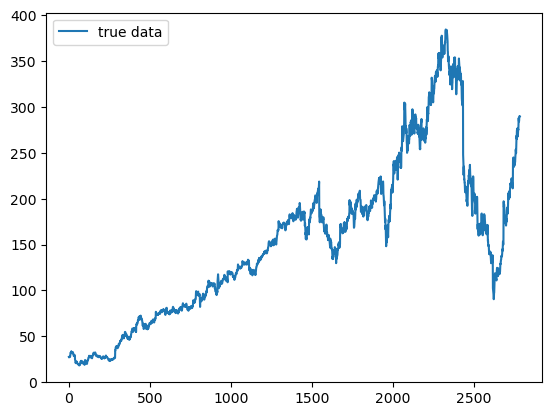

In [145]:
### PLOT TRAIN DATA

import matplotlib.pyplot as plt
backcast, forecast = model(torch.Tensor(x_train[1]))

bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

actual = x_train[1] + y_train[1]

yyy = [x[0] for x in y_train]
print(yyy)
print(train_outputs[:2800])

plt.plot([0,0,0,0,0] + train_outputs[:2800], label="outputs")

plt.plot(yyy, label="true data")
plt.legend()


In [136]:
##Eval
outputs = []

eval_loss = []
model.eval()

with torch.no_grad():


    for i in range(len(x_test)):
        loss = 0
        x = torch.Tensor(x_test[i])
        y = torch.Tensor(y_test[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        #eval_loss.append(loss.item())

yyy_test = [x[0] for x in y_test]
print(len(yyy_test))



143


[277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833984375, 277.6204833

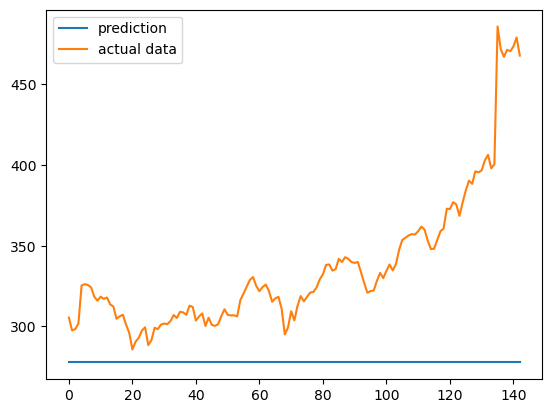

In [137]:

plt.plot( outputs, label = "prediction")
plt.plot(yyy_test, label="actual data")
plt.legend()
print(outputs)

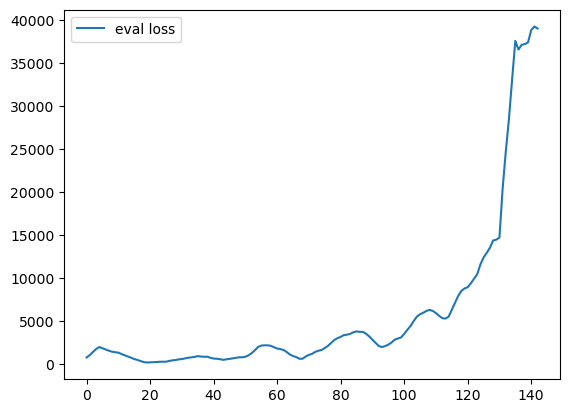

In [139]:
##Plot loss
import matplotlib.pyplot as plt


plt.plot(eval_loss, label = "eval loss")
#plt.plot(train_loss, label="train loss")

plt.legend()
